## Import and Clean Data

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import json
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression
import statsmodels.api as sm
from sklearn.linear_model import Lasso
import tensorflow as tf

df = pd.read_csv('menu_items.csv')
df2 = pd.read_csv("nutrition_data.csv")
df2.rename(columns={'item_id': 'id'}, inplace=True)
df = df.merge(df2, on="id", how="left")
df = df.sort_values(by='review_count', ascending=False).drop_duplicates(subset='id', keep='first')
df = df.sort_values(by='review_count', ascending=False).drop_duplicates(subset='name', keep='first')

C = df['rating'].mean()

# Step 2: Set minimum number of reviews required to be credible
m = 5  # You can adjust this based on your dataset

# Step 3: Compute the weighted rating
df['IMDB_rating'] = (
    (df['review_count'] / (df['review_count'] + m)) * df['rating'] +
    (m / (df['review_count'] + m)) * C
)
df = df[df["review_count"] >= 5]
df = df[df["calories"] >= 50]
relevant_columns = ["meat", "animal_products", "alcohol", 'coconut', 'dairy', 'egg', 'fish', 'gluten', 'peanuts', 'pork', 'sesame', 'shellfish', 'soy', 'tree_nut', 'wheat', "calories", "total_fat", "saturated_fat", "trans_fat", 'cholesterol', 'sodium', 'total_carbohydrate', 'dietary_fiber', 'total_sugars', "protein", "iron", "rating", "review_count", "IMDB_rating", "name", "course"]
df = df[relevant_columns]
df[df.select_dtypes(include=['bool']).columns] = df.select_dtypes(include=['bool']).astype(int)
df['total_fat'] = df['total_fat'].str.extract(r'(\d+\.\d+|\d+)').astype(float)
df['saturated_fat'] = df['saturated_fat'].str.extract(r'(\d+\.\d+|\d+)').astype(float)
df['trans_fat'] = df['trans_fat'].str.extract(r'(\d+\.\d+|\d+)').astype(float)
df['cholesterol'] = df['cholesterol'].str.extract(r'(\d+\.\d+|\d+)').astype(float)
df['sodium'] = df['sodium'].str.extract(r'(\d+\.\d+|\d+)').astype(float)
df['total_carbohydrate'] = df['total_carbohydrate'].str.extract(r'(\d+\.\d+|\d+)').astype(float)
df['dietary_fiber'] = df['dietary_fiber'].str.extract(r'(\d+\.\d+|\d+)').astype(float)
df['total_sugars'] = df['total_sugars'].str.extract(r'(\d+\.\d+|\d+)').astype(float)
df['protein'] = df['protein'].str.extract(r'(\d+\.\d+|\d+)').astype(float)
df['iron'] = df['iron'].str.extract(r'(\d+\.\d+|\d+)').astype(float)

In [3]:
train_df, test_df = train_test_split(df, test_size=0.15, random_state=100)
train_X = train_df[["meat", "animal_products", "alcohol", 'coconut', 'dairy', 'egg', 'fish', 'gluten', 'peanuts', 'pork', 'sesame', 'shellfish', 'soy', 'tree_nut', 'wheat', "calories","total_fat", "saturated_fat", "trans_fat", 'cholesterol', 'sodium', 'total_carbohydrate', 'dietary_fiber', 'total_sugars', "protein", "iron"]]
train_y = train_df["IMDB_rating"]
test_X = test_df[["meat", "animal_products", "alcohol", 'coconut', 'dairy', 'egg', 'fish', 'gluten', 'peanuts', 'pork', 'sesame', 'shellfish', 'soy', 'tree_nut', 'wheat', "calories", "total_fat", "saturated_fat", "trans_fat", 'cholesterol', 'sodium', 'total_carbohydrate', 'dietary_fiber', 'total_sugars', "protein", "iron"]]
test_y = test_df["IMDB_rating"]
print(train_X.shape)
print(len(test_df))

(634, 26)
112


## Baseline

In [4]:
train_mean = train_y.mean()

y_hat = [train_mean] * len(test_y)
baseline_mse = mean_squared_error(y_hat, test_y)
print(baseline_mse)

0.5578801070121676


## OLS

In [16]:
train_X_const = sm.add_constant(train_X)

ols = sm.OLS(train_y, train_X_const).fit()
y_hat = ols.predict(sm.add_constant(test_X))
ols_mse = mean_squared_error(y_hat, test_y)
print(ols_mse)
print(ols.summary())

0.46623886986277047
                            OLS Regression Results                            
Dep. Variable:            IMDB_rating   R-squared:                       0.218
Model:                            OLS   Adj. R-squared:                  0.185
Method:                 Least Squares   F-statistic:                     6.513
Date:                Sun, 04 May 2025   Prob (F-statistic):           8.15e-20
Time:                        22:55:33   Log-Likelihood:                -598.52
No. Observations:                 634   AIC:                             1251.
Df Residuals:                     607   BIC:                             1371.
Df Model:                          26                                         
Covariance Type:            nonrobust                                         
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
const           

## Lasso

In [6]:
lasso = Lasso(alpha=0.1)

lasso.fit(train_X, train_y)

y_hat = lasso.predict(train_X)

lasso_mse = mean_squared_error(train_y, y_hat)
print(lasso_mse)
non_zero_coef_idx = lasso.coef_ != 0
features_left = train_X.columns[non_zero_coef_idx]
print(features_left)
coef_df = pd.DataFrame({
    'Feature': train_X.columns,
    'Coefficient': lasso.coef_
})
print(coef_df[['Feature', 'Coefficient']])


0.4234659529297833
Index(['calories', 'saturated_fat', 'cholesterol', 'sodium',
       'total_carbohydrate', 'dietary_fiber', 'total_sugars', 'protein',
       'iron'],
      dtype='object')
               Feature  Coefficient
0                 meat     0.000000
1      animal_products     0.000000
2              alcohol     0.000000
3              coconut    -0.000000
4                dairy     0.000000
5                  egg     0.000000
6                 fish     0.000000
7               gluten     0.000000
8              peanuts    -0.000000
9                 pork     0.000000
10              sesame     0.000000
11           shellfish    -0.000000
12                 soy     0.000000
13            tree_nut     0.000000
14               wheat     0.000000
15            calories    -0.000428
16           total_fat    -0.000000
17       saturated_fat     0.017624
18           trans_fat     0.000000
19         cholesterol     0.000860
20              sodium    -0.000142
21  total_carbohy

## NN

In [7]:
model = tf.keras.models.Sequential([
  tf.keras.layers.Input(shape=(len(train_X.columns),)),
  tf.keras.layers.Dense(256, activation='relu'),
  tf.keras.layers.Dropout(0.25),
  tf.keras.layers.Dense(256, activation='relu'),
  tf.keras.layers.Dropout(0.25),
  tf.keras.layers.Dense(256, activation='relu'),
  tf.keras.layers.Dropout(0.25),
  tf.keras.layers.Dense(256, activation='relu'),
  tf.keras.layers.Dropout(0.25),
  tf.keras.layers.Dense(256, activation='relu'),
  tf.keras.layers.Dense(1)
])

loss_fn = tf.keras.losses.MSE
model.compile(optimizer="adam",
              loss=loss_fn,
              metrics=['MeanSquaredError'])
print(model.summary())

history = model.fit(
    train_X, train_y, 
    epochs=1000, 
    batch_size=32,)

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 256)            │         6,912 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 256)            │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 256)            │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 256)            │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 256)            │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 1)              │           257 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 270,337 (1.03 MB)

 Trainable params: 270,337 (1.03 MB)

 Non-trainable params: 0 (0.00 B)

None
Epoch 1/1000
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - MeanSquaredError: 887.0031 - loss: 887.0031     
Epoch 2/1000
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - MeanSquaredError: 50.3179 - loss: 50.3179 
Epoch 3/1000
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - MeanSquaredError: 32.2935 - loss: 32.2935 
Epoch 4/1000
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - MeanSquaredError: 21.8761 - loss: 21.8761 
Epoch 5/1000
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - MeanSquaredError: 15.6209 - loss: 15.6209
Epoch 6/1000
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - MeanSquaredError: 19.0162 - loss: 19.0162
Epoch 7/1000
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - MeanSquaredError: 14.9230 - loss: 14.9230
Epoch 8/1000
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - MeanSquaredError: 13.3344 - loss: 13.3344
Epoch 9/1000
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - MeanSquaredError: 10.8385 - loss: 10.8385
Epoch 10/1000
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - MeanSquaredError: 12.7541 - loss: 12.7541
Epoch 11/1000
20/20 ━━━━

In [8]:
y_hat = model.predict(test_X)
nn_mse = mean_squared_error(test_y, y_hat)
print(nn_mse)

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
0.5122706937480322


## Data Exploration and Visualizations:

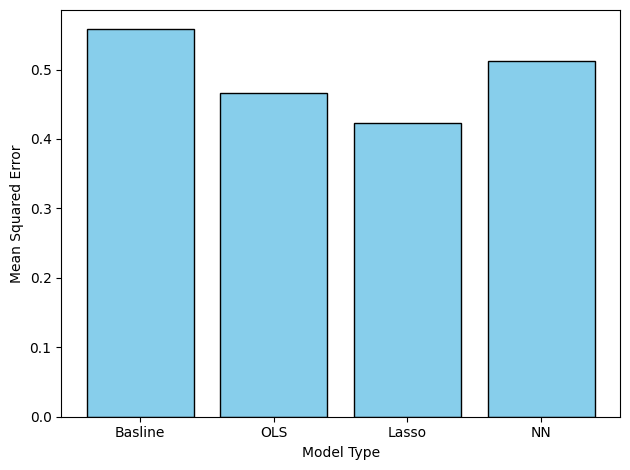

In [9]:
data = {'fruit': ['Basline', 'OLS', 'Lasso', "NN"],
        'color': [baseline_mse, ols_mse, lasso_mse, nn_mse]}
course_counts = pd.DataFrame(data)


plt.bar(course_counts['fruit'], course_counts['color'], color="skyblue", edgecolor="black")
plt.xlabel('Model Type')
plt.ylabel('Mean Squared Error')
#plt.title('Bar Graph of num by name')
plt.tight_layout()
plt.xticks(rotation=0)

plt.show()

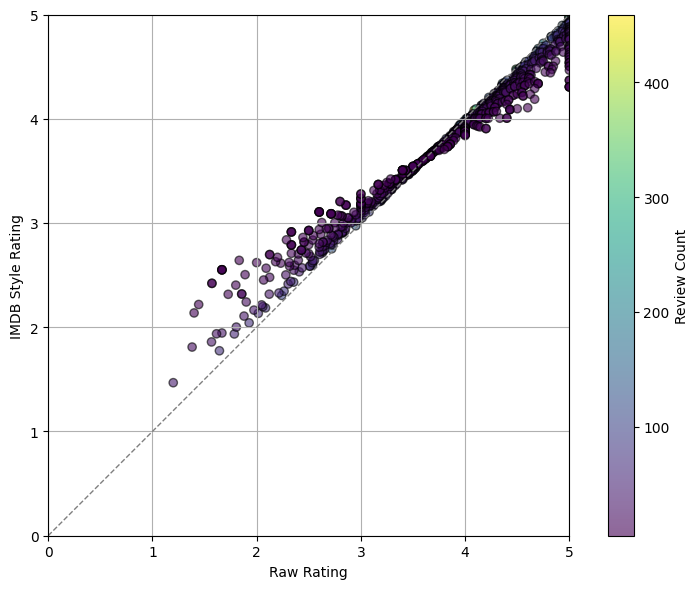

In [10]:
plt.figure(figsize=(8, 6))  
scatter = plt.scatter(
    df['rating'],
    df['IMDB_rating'],
    c=df['review_count'],
    cmap='viridis',
    alpha=0.6,
    edgecolors='k'
)

plt.plot([0, 5.5], [0, 5.5], linestyle='--', color='gray', linewidth=1)

plt.xlabel('Raw Rating')
plt.ylabel('IMDB Style Rating')
plt.xlim(0, 5)
plt.ylim(0, 5)
plt.gca().set_aspect('equal')
#plt.title('Visualization of Rating to IMDB Style Rating Transformation')

cbar = plt.colorbar(scatter)
cbar.set_label('Review Count')

plt.grid(True)
plt.tight_layout()
plt.show()

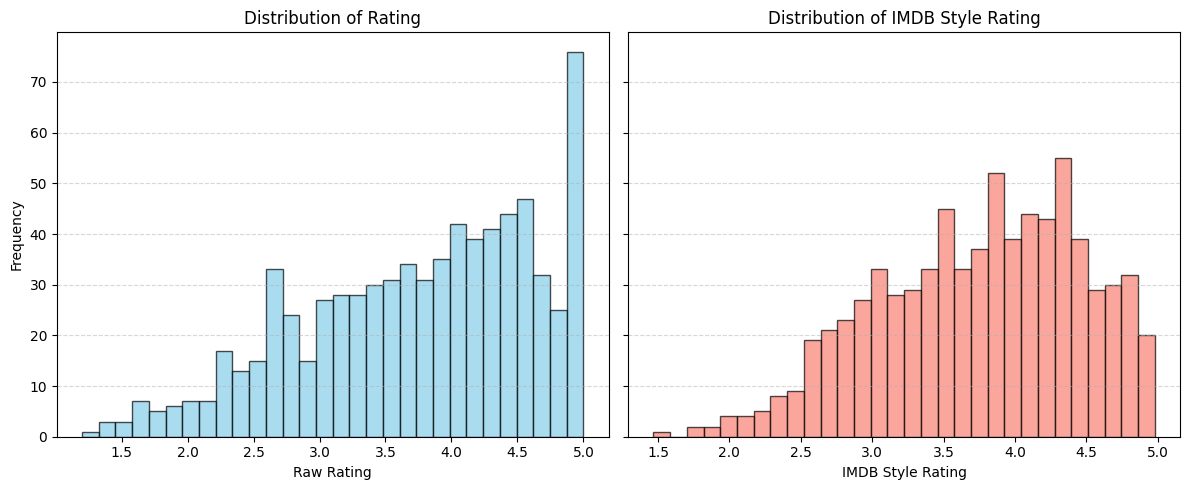

In [11]:
fig, axes = plt.subplots(1, 2, figsize=(12, 5), sharey=True)

axes[0].hist(df['rating'], bins=30, color='skyblue', edgecolor='black', alpha=0.7)
axes[0].set_title('Distribution of Rating')
axes[0].set_xlabel('Raw Rating')
axes[0].set_ylabel('Frequency')
axes[0].grid(axis='y', linestyle='--', alpha=0.5)

axes[1].hist(df['IMDB_rating'], bins=30, color='salmon', edgecolor='black', alpha=0.7)
axes[1].set_title('Distribution of IMDB Style Rating')
axes[1].set_xlabel('IMDB Style Rating')
axes[1].grid(axis='y', linestyle='--', alpha=0.5)

plt.tight_layout()
plt.show()

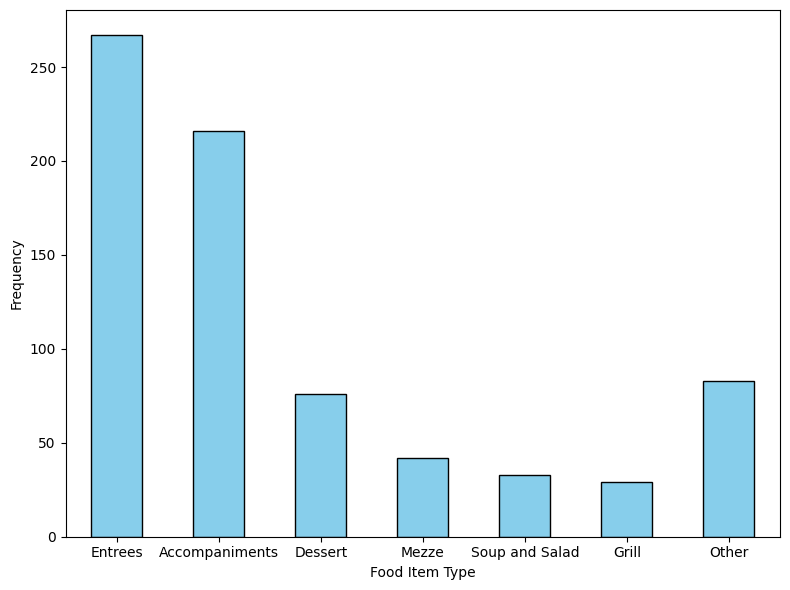

In [12]:
course_counts = df['course'].value_counts()

top_courses = course_counts.head(6)
other_courses = course_counts.iloc[6:].sum()


course_counts = pd.concat([top_courses, pd.Series({'Other': other_courses})])

plt.figure(figsize=(8, 6))
course_counts.plot(kind='bar', color='skyblue', edgecolor='black')

plt.xticks(rotation=0)

plt.xlabel('Food Item Type')
plt.ylabel('Frequency')
#plt.title('Bar Graph of Food Item Type Frequency')

plt.tight_layout()
plt.show()

In [13]:
top_10 = (
    df             
    .sort_values(by='IMDB_rating', ascending=False)  
    .head(10)                                
)
print(top_10[['name', 'IMDB_rating', 'rating', 'review_count']])

                                           name  IMDB_rating  rating  \
32965              Yale Breaded Chicken Tenders     4.980556   5.000   
39220                              Garlic Bread     4.973904   5.000   
11777  Food Truck-Style Grilled Cheese Sandwich     4.973552   4.994   
39364       Lemon and Panko Fried Chicken Katsu     4.945769   5.000   
3236                          Homemade Brownies     4.940159   5.000   
39619                      Raspberry Cheesecake     4.934514   5.000   
24845                   Shoestring French Fries     4.930585   5.000   
28434                      Chocolate Croissants     4.930585   5.000   
39840                               Spiced Naan     4.929168   5.000   
31041                        Chicken Quesadilla     4.922436   4.990   

       review_count  
32965           352  
39220           261  
11777           333  
39364           123  
3236            111  
39619           101  
24845            95  
28434            95  
39840    

In [14]:
top_10 = (
    df              
    .sort_values(by='IMDB_rating', ascending=True) 
    .head(10)                                
)
print(top_10[['name', 'IMDB_rating', 'rating', 'review_count']])

                                          name  IMDB_rating  rating  \
21535             Escarole and White Bean Bake     1.467966   1.200   
20690                           Creamy Polenta     1.774246   1.643   
28338  Acorn Squash with Crunchy Tofu Stuffing     1.809980   1.381   
36031               Okra and Mushroom Etouffee     1.859100   1.567   
29976                    Golden Shepherd's Pie     1.935647   1.786   
29396                   Beef Chuck "Pizzaiola"     1.937048   1.615   
29246                        Tuscan Bean Puree     1.944814   1.667   
22858                      Chili Verde Gardein     2.001380   1.805   
27657              Chef Stu's Matzoh Ball Soup     2.041763   1.928   
22935           Spicy Creole Eggplant Sandwich     2.106986   1.879   

       review_count  
21535            40  
20690            70  
28338            21  
36031            30  
29976            56  
29396            26  
29246            30  
22858            41  
27657            69 